In [65]:
import re  
import math  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [66]:
Modelos_a_procesar = ['DQN','DDQN', 'DDQN_REPLAY', 'DUELING_DQN_REPLAY']
file_Output = 'output-train-'
target_reward = 20
parse_output=False
to_csv=True

In [67]:
def parse_datos_episodio_desde_archivo(ruta_archivo, ruta_csv, to_csv=False):
    """
    Analiza el contenido de un archivo dado para extraer campos de datos específicos para cada episodio,
    estrictamente comprobando el formato de la segunda línea para evitar datos "basura".
    Además, calcula la "Recompensa acumulada media" de forma progresiva.

    Argumentos:
        ruta_archivo (str): La ruta al archivo de texto de entrada que contiene la información del episodio.

    Retorna:
        pandas.DataFrame: Un DataFrame con las columnas especificadas para cada episodio,
                          incluyendo la "Recompensa acumulada media",
                          o None si el archivo no se puede leer.
    """
    try:
        # Intenta abrir y leer el archivo
        with open(ruta_archivo, 'r', encoding='utf-8') as f:
            texto = f.read()
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{ruta_archivo}'. Por favor, verifica la ruta.")
        return None
    except Exception as e:
        print(f"Ocurrió un error al leer el archivo: {e}")
        return None

    datos = [] # Lista para almacenar los diccionarios de cada episodio
    lineas = texto.strip().split('\n') # Divide el texto en líneas y elimina espacios en blanco al inicio/final
    i = 0 # Índice para recorrer las líneas

    while i < len(lineas):
        linea1 = lineas[i]
        
        # Expresión regular para la primera línea del episodio (Ej: 📈 Episodio X: Recompensa total...)
        # Permanece estricta ya que es el marcador de inicio de un episodio.
        coincidencia1 = re.match(
            r"📈 Episodio (\d+): Recompensa total \(clipped\): ([\d.]+), Pasos: (\d+), Mean Reward Calculado: ([\d.]+)",
            linea1
        )

        if coincidencia1:
            episodio = int(coincidencia1.group(1))
            # Si la primera línea coincide, extrae los datos principales del episodio
            datos_episodio = {
                'Episodio': episodio,
                'Recompensa total': None,
                'Pasos': int(coincidencia1.group(3)),
                'Mean Reward Calculado': float(coincidencia1.group(4))
            }

            # Inicializa las columnas de la segunda línea a None por si no se encuentran
            datos_episodio['duracion (s)'] = None
            datos_episodio['steps per second'] = None
            datos_episodio['Recompensa Episodio'] = None
            datos_episodio['mean action'] = None
            datos_episodio['loss'] = None


            segunda_linea_encontrada = False
            j = i + 1 # Inicia la búsqueda de la segunda línea a partir de la siguiente

            # Bucle interno para buscar la línea de métricas detalladas (la "segunda línea")
            while j < len(lineas):
                potencial_linea2 = lineas[j]
                
                # Criterio clave REVISADO: Buscamos "episode: <numero_episodio_actual>," en la línea.
                # Esto es más robusto ante variaciones de espacios o "basura" antes de las métricas.
                numero_episodio_actual = coincidencia1.group(1) # Obtenemos el número de episodio de la línea 1
                if re.search(rf"episode:\s*{re.escape(numero_episodio_actual)},", potencial_linea2):
                    
                    # Si esta línea contiene el número de episodio al que corresponde,
                    # es muy probable que sea nuestra línea de métricas detalladas.
                    # Extrae las métricas individuales de forma flexible.
                    duracion_coincidencia = re.search(r"duration:\s*([\d.]+)s", potencial_linea2)
                    pasos_por_segundo_coincidencia = re.search(r"steps\s*(?:per\s*)?second:\s*(\d+)", potencial_linea2)
                    recompensa_episodio_coincidencia = re.search(r"episode\s*reward:\s*([\d.]+)", potencial_linea2)
                    accion_media_coincidencia = re.search(r"mean\s*action:\s*([\d.]+)", potencial_linea2)
                    perdida_coincidencia = re.search(r"loss:\s*([-\d.]+)", potencial_linea2) # Maneja '--'

                    datos_episodio['duracion (s)'] = float(duracion_coincidencia.group(1)) if duracion_coincidencia else 0
                    datos_episodio['steps per second'] = int(pasos_por_segundo_coincidencia.group(1)) if pasos_por_segundo_coincidencia else None
                    datos_episodio['Recompensa Episodio'] = float(recompensa_episodio_coincidencia.group(1)) if recompensa_episodio_coincidencia else None
                    datos_episodio['mean action'] = float(accion_media_coincidencia.group(1)) if accion_media_coincidencia else None
                    
                    # Manejo especial para 'loss', que puede ser '--'
                    if perdida_coincidencia and perdida_coincidencia.group(1) != '--':
                        datos_episodio['loss'] = float(perdida_coincidencia.group(1))
                    else:
                        datos_episodio['loss'] = None
                    
                    segunda_linea_encontrada = True
                    i = j # Actualiza el índice principal 'i' a la posición de esta segunda línea
                    break # Sale del bucle interno, ya encontramos nuestra línea2

                # Si encontramos el inicio de un NUEVO episodio, significa que la línea de métricas
                # para el episodio actual no existe o no tiene el formato esperado.
                elif re.match(r"📈 Episodio \d+:", potencial_linea2):
                    break # Salimos del bucle interno sin encontrar la segunda línea
                
                j += 1 # Avanza a la siguiente línea para buscar la segunda línea

            datos.append(datos_episodio) # Añade los datos del episodio (completos o con Nones)
            i += 1 # Incrementa el índice principal 'i'. El bucle principal continuará desde aquí.
                   # Si se encontró la línea2, 'i' ya se actualizó a 'j' y este i+=1 lo mueve a j+1.
                   # Si no se encontró la línea2, 'i' sigue en su valor original y este i+=1 lo mueve a i+1.
        else:
            i += 1 # Si la línea actual no es el inicio de un episodio, simplemente avanza a la siguiente línea
                   # (esto ignora las líneas de "basura" que no son ni inicio de episodio ni la línea de métricas esperada).

    df = pd.DataFrame(datos)    
    # Calcular el promedio de los últimos 100 episodios (media móvil)
    # min_periods=1 asegura que la media se calcule incluso si hay menos de 100 episodios al principio
    df['Recompensa total'] = round(df['Recompensa Episodio'].rolling(window=100, min_periods=1).mean(), 2)  
    
    # --- CÁLCULO DE TIEMPO ACUMULADO ---
    # Convertir 'duration (s)' a tipo numérico, forzando errores a NaN
    df['duration (s)'] = pd.to_numeric(df['duracion (s)'], errors='coerce')
    # Rellenar cualquier NaN en duration (s) con 0 para el cálculo acumulado si es apropiado
    df['duration (s)'] = df['duration (s)'].fillna(0)
    # Calcular el tiempo acumulado sumando las duraciones individuales
    df['Tiempo acumulado'] = df['duration (s)'].cumsum()    
    # --- FIN CÁLCULO DE TIEMPO ACUMULADO ---   
    
    # Opcional: guardar el DataFrame en un archivo CSV
    if(to_csv):
        df.to_csv(ruta_csv, index=False)
    
    return df                          

In [68]:
# Graficar recompensas
# Crear subplots (uno al lado del otro)
def graficar_reward(datos, rewards):
    # Definir colores para cada modelo
    colores = ['blue', 'orange', 'green', 'purple', 'red', 'cyan']
    # Parámetros
    max_por_fila = 2  # Máximo de subplots por fila
    num_modelos = len(rewards_ep)
    num_filas = math.ceil(num_modelos / max_por_fila)
    num_columnas = min(num_modelos, max_por_fila)
    
    # Crear subplots dinámicos
    fig, axs = plt.subplots(num_filas, num_columnas, figsize=(8 * num_columnas, 5 * num_filas))
    axs = np.array(axs).reshape(-1)  # Asegura que axs sea una lista 1D para iterar    

    # Dibujar cada modelo por separado
    for i, (nombre, datos_gf) in enumerate(datos.items()):
        axs[i].plot(datos_gf, label='Recompensa/Episodio', color=colores[i % len(colores)], alpha=0.3)
        recompensas_total = rewards[nombre]
        axs[i].plot(recompensas_total, label='Recompensa Total', color=colores[i % len(colores)], linewidth=2)
        axs[i].axhline(y=target_reward, color='black', linestyle='--', label='Objetivo')
        axs[i].set_title(f'Recompensa por Episodio y Recompensa Acumulada Media {nombre}')
        axs[i].set_xlabel('Número de Episodios')
        axs[i].set_ylabel('Recompensa')
        axs[i].legend()
        axs[i].grid(True)

    # Eliminar subplots vacíos si sobran
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Título general
    fig.suptitle("Comparación de Recompensas por Episodio y Totales entre Modelos", fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # deja espacio arriba para el suptitle
    plt.show()    
    

In [69]:
def graficar_superpuesto(datos, titulo, etiqueta, target_reward=0):
    # Graficar curvas
    plt.figure(figsize=(12, 6))
    for nombre, datos_gf in datos.items():
        plt.plot(datos_gf, label=nombre)

    if(target_reward>0):
        plt.axhline(y=target_reward, color='black', linestyle='--', label='Objetivo')
    plt.title(f'Comparación de {titulo} por Episodio (Evaluación)')
    plt.xlabel('Número de Episodios')
    plt.ylabel(f'{etiqueta}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [74]:
# Graficar curvas
# Crear subplots (uno al lado del otro)
def graficar_repartido(datos, titulo, etiqueta, target_reward=0):
    # Definir colores para cada modelo
    colores = ['blue', 'orange', 'green', 'purple', 'red', 'cyan']
    # Parámetros
    max_por_fila = 2  # Máximo de subplots por fila
    num_modelos = len(rewards_ep)
    num_filas = math.ceil(num_modelos / max_por_fila)
    num_columnas = min(num_modelos, max_por_fila)
    
    # Crear subplots dinámicos
    fig, axs = plt.subplots(num_filas, num_columnas, figsize=(8 * num_columnas, 5 * num_filas))
    axs = np.array(axs).reshape(-1)  # Asegura que axs sea una lista 1D para iterar    

    # Dibujar cada modelo por separado
    for i, (nombre, datos_gf) in enumerate(datos.items()):
        axs[i].plot(datos_gf, label='Recompensa/Episodio', color=colores[i % len(colores)], alpha=0.3)  
        if(target_reward>0):
            axs[i].axhline(y=target_reward, color='black', linestyle='--', label='Objetivo')
        axs[i].set_title(f'{titulo} por Episodio - {nombre}')
        axs[i].set_xlabel('Número de Episodios')
        axs[i].set_ylabel(f'{etiqueta}')
        axs[i].legend()
        axs[i].grid(True)

    # Eliminar subplots vacíos si sobran
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Título general
    fig.suptitle(f"Comparación de {titulo} por Episodio y Totales entre Modelos", fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # deja espacio arriba para el suptitle
    plt.show()    
    

parse_datos_episodio_desde_archivo('output-train-DDQN.txt', 'output-train-DDQN.csv', to_csv=True) 

In [79]:
target_reward = 20
parse_output=False
to_csv=True

def procesar_fichero(Modelos_a_procesar):
    resumen_resultados = []
    rewards_ep = {}
    rewards = {}
    loss = {}
    pasos = {}
    duracion = {}

    for name in Modelos_a_procesar:
        df_desde_csv = None
        ruta_del_archivo = f'{file_Output}{name}.txt'
        ruta_archivo_csv = f'{file_Output}{name}.csv'
        # Asegúrate de que el fichero esté en la misma carpeta, o proporciona la ruta completa
        # Parseo del fichero:
        # Controlamos si es necesario parsear el output. Si ya lo hemos hecho no es necesario
        if(parse_output):    
            df_desde_archivo = parse_datos_episodio_desde_archivo(ruta_del_archivo, ruta_archivo_csv, to_csv=to_csv)   
        # Opcional: guardar el DataFrame en un archivo CSV
        if(to_csv):    
            try:
                # Lee el CSV. Pandas es muy bueno infiriendo el formato por defecto.
                df_desde_csv = pd.read_csv(ruta_archivo_csv, sep=",") 
            except FileNotFoundError:
                print(f"Error: No se encontró el csv '{ruta_archivo_csv}'. Por favor, verifica la ruta.")
            except Exception as e:
                print(f"Ocurrió un error al leer el cvs: {e}")
                
        if df_desde_csv is not None:    
            rewards_df = df_desde_csv['Recompensa total']
            mean = np.mean(rewards_df)
            std = np.std(rewards_df)
            max_r = np.max(rewards_df)
            min_r = np.min(rewards_df)
            objetivo = mean >= target_reward
            max_e = np.max(df_desde_csv['Recompensa Episodio'])

            resumen_resultados.append({
                "Modelo": name,
                "Media (100)": mean,
                "STD (100)": std,
                "Máximo (100)": max_r,
                "Mínimo (100)": min_r,
                "Máximo episodio": max_e,                
                "Objetivo alcanzado": objetivo                              
            })

            rewards_ep[name] = df_desde_csv['Recompensa Episodio']
            rewards[name] = df_desde_csv['Recompensa total']
            loss[name] = df_desde_csv['loss']
            pasos[name] = df_desde_csv['Pasos']
            duracion[name] = df_desde_csv['Tiempo acumulado'] / 3600 
            
    return resumen_resultados, rewards, rewards_ep, loss, pasos, duracion

Error: No se encontró el csv 'output-train-DDQN_REPLAY.csv'. Por favor, verifica la ruta.

📊 COMPARATIVA DE MODELOS:
            Modelo  Media (100)  STD (100)  Máximo (100)  Mínimo (100)  Máximo episodio  Objetivo alcanzado
               DQN    20.212887   5.098419         26.59           8.0             53.0                True
              DDQN    20.283780   4.735162         25.86           8.0             52.0                True
DUELING_DQN_REPLAY    20.938807   5.236237         27.56           8.0             51.0                True


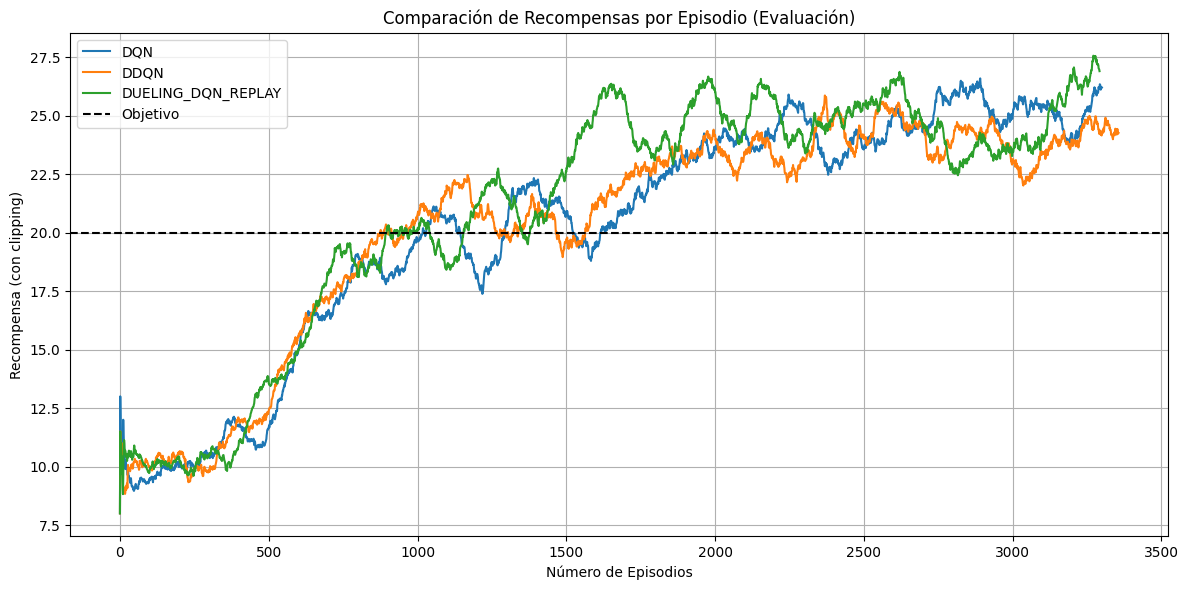

In [80]:
resumen_resultados, rewards, rewards_ep, loss, pasos, duracion = procesar_fichero(Modelos_a_procesar)

df_resultados = pd.DataFrame(resumen_resultados)
print("\n📊 COMPARATIVA DE MODELOS:")
print(df_resultados.to_string(index=False))

graficar_superpuesto(rewards, 'Recompensas', 'Recompensa (con clipping)', target_reward=20)
  

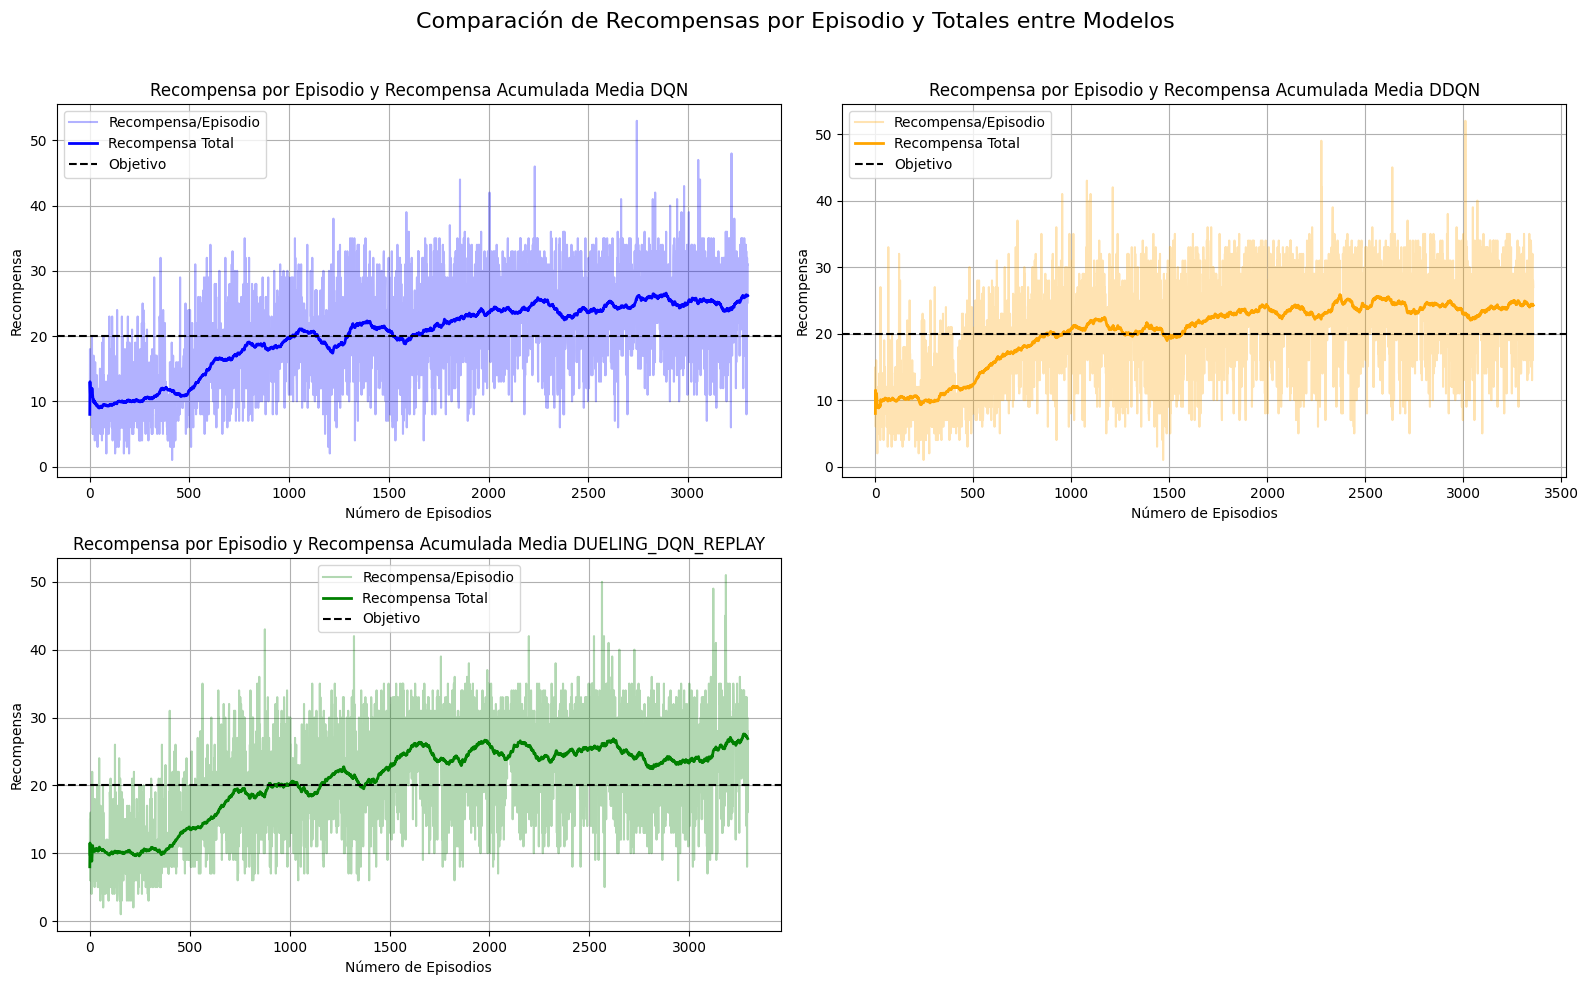

In [81]:
graficar_reward(rewards_ep, rewards)

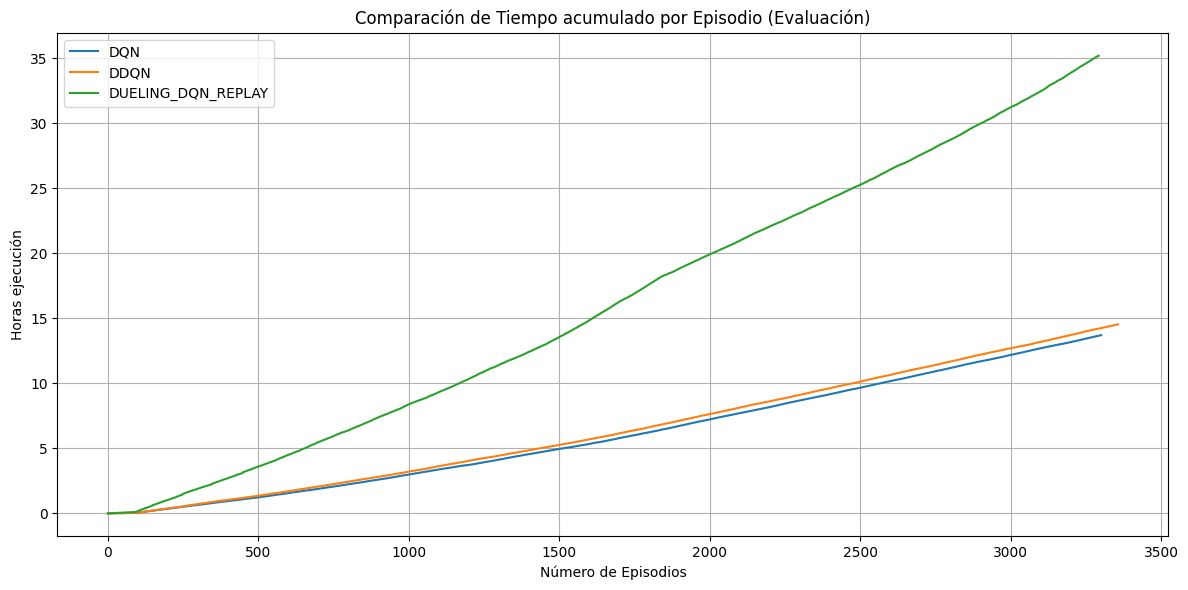

In [82]:
graficar_superpuesto(duracion, 'Tiempo acumulado', 'Horas ejecución', target_reward=0)

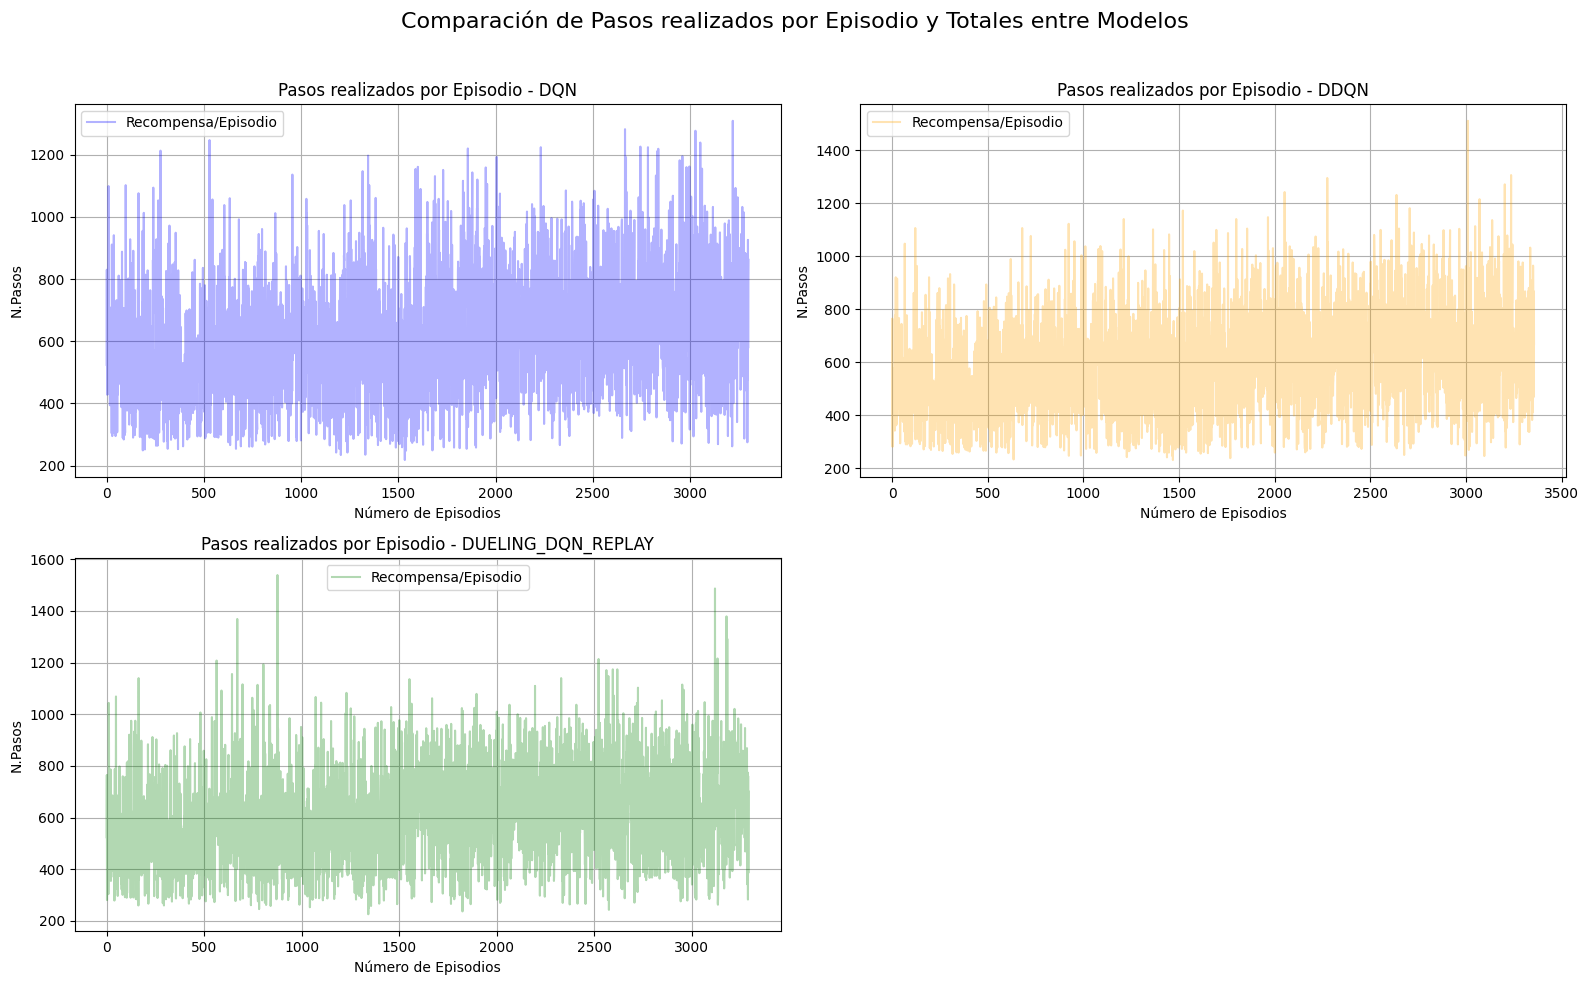

In [83]:
graficar_repartido(pasos, 'Pasos realizados', 'N.Pasos', target_reward=0)

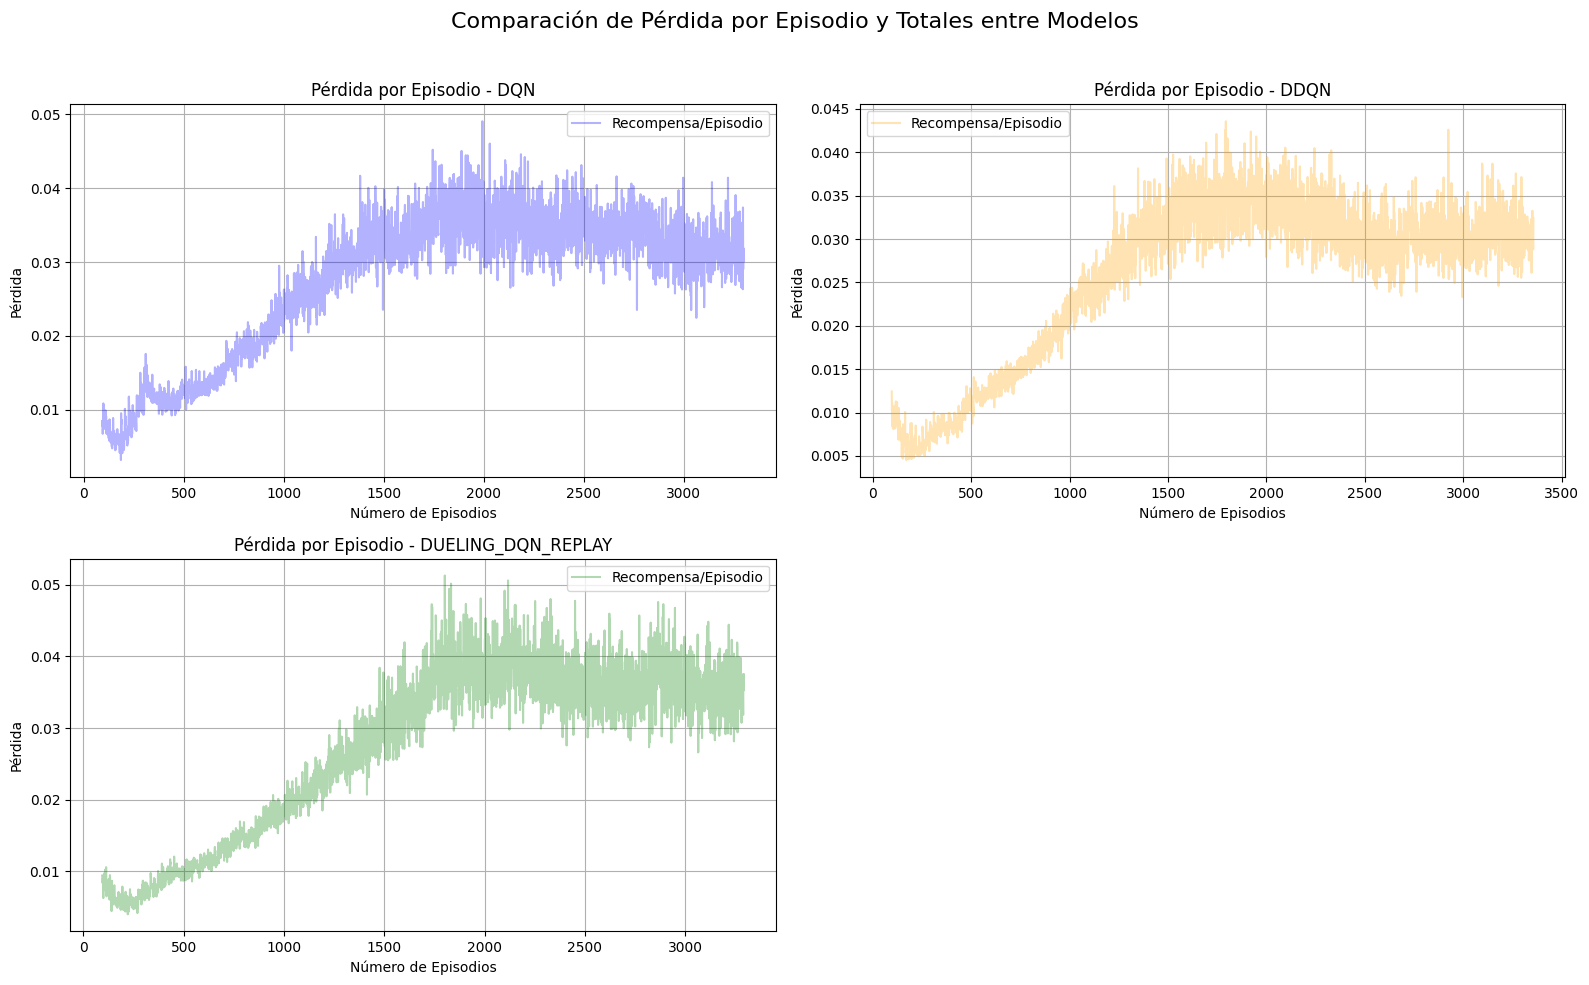

In [84]:
graficar_repartido(loss, 'Pérdida', 'Pérdida', target_reward=0)


📊 COMPARATIVA DE MODELOS DDQN/DQN:
  Modelo     Media      STD  Máximo  Mínimo  Objetivo alcanzado
DDQN_001 20.752674 4.518879   25.85    8.00                True
DQN_5000 20.410102 4.961271   25.56    8.00                True
  DQN_05 21.591063 5.093945   27.48    8.14                True
 DDQN_05 21.339776 3.888219   26.94   10.89                True


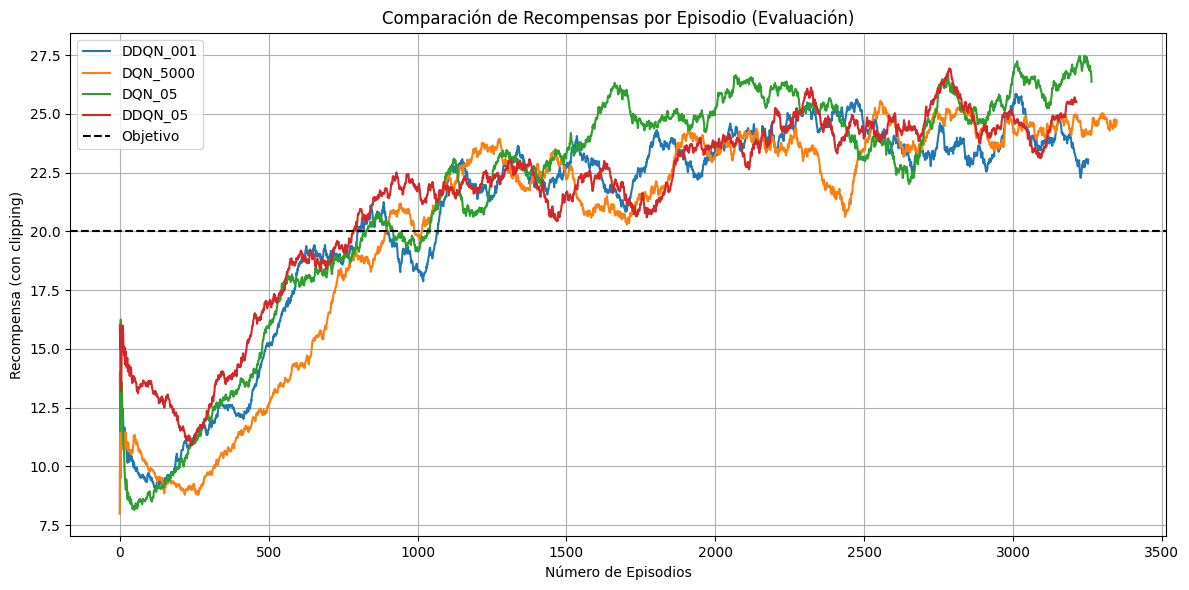

In [20]:
Modelos_a_procesar_2 = ['DDQN_001','DQN_5000', 'DQN_05', 'DDQN_05']

resumen_resultados, rewards, rewards_ep, loss, pasos, duracion = procesar_fichero(Modelos_a_procesar_2)
df_resultados = pd.DataFrame(resumen_resultados)
print("\n📊 COMPARATIVA DE MODELOS DDQN/DQN:")
print(df_resultados.to_string(index=False))

graficar_superpuesto(rewards, 'Recompensas', 'Recompensa (con clipping)', target_reward=20)
  

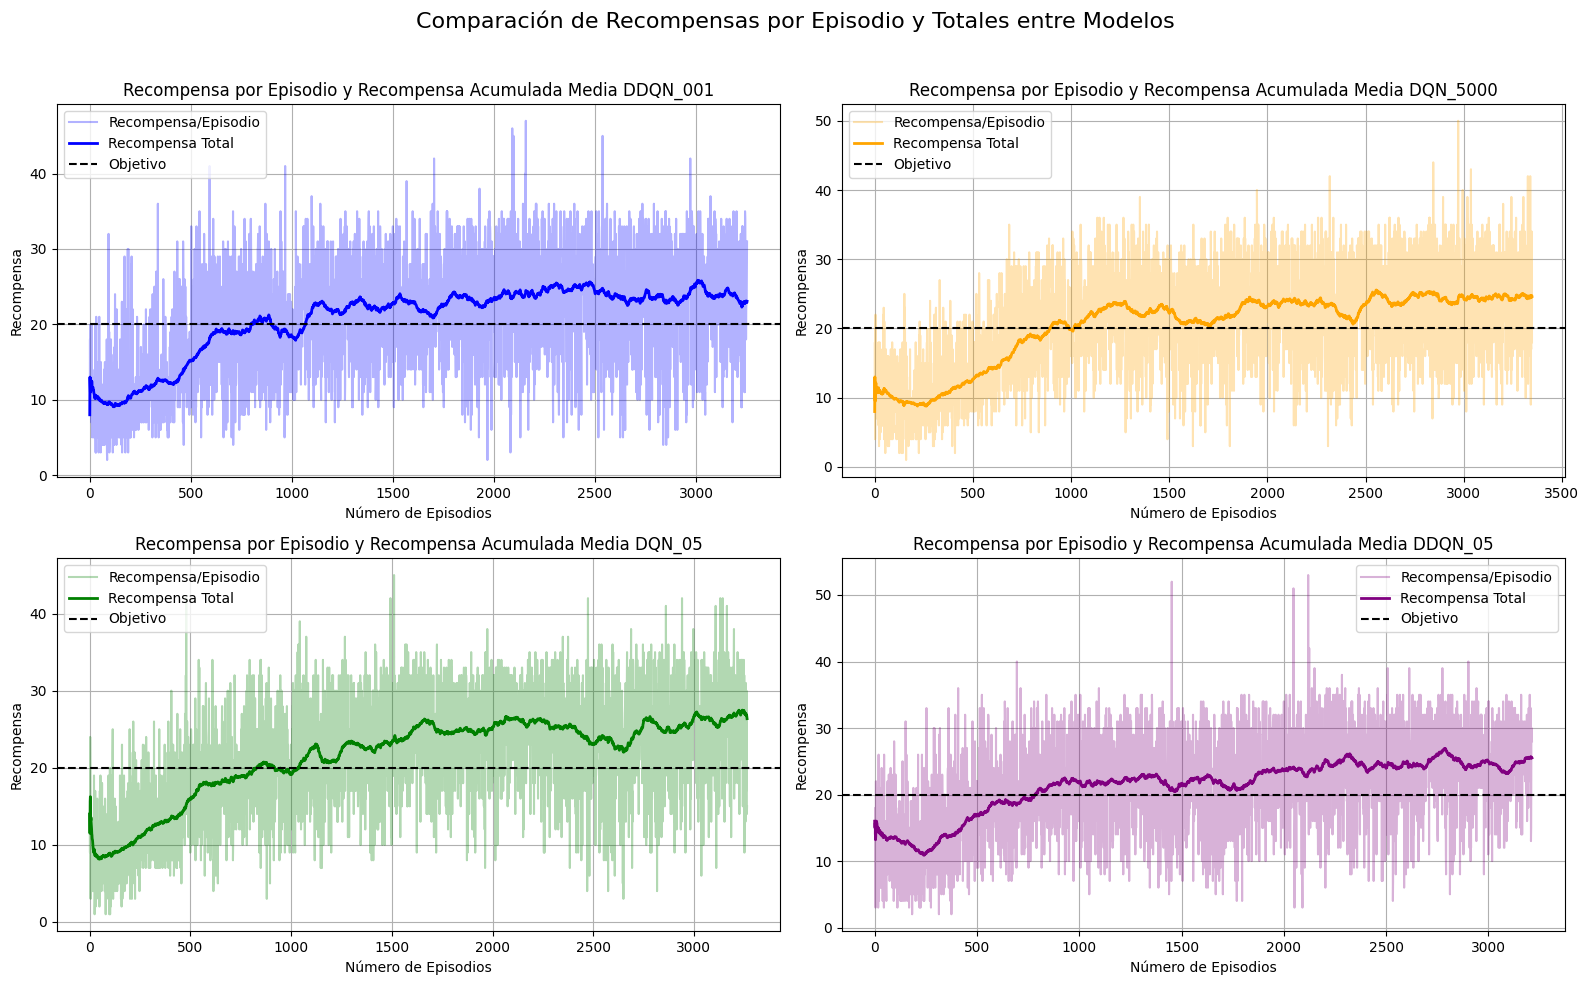

In [21]:
graficar_reward(rewards_ep, rewards)

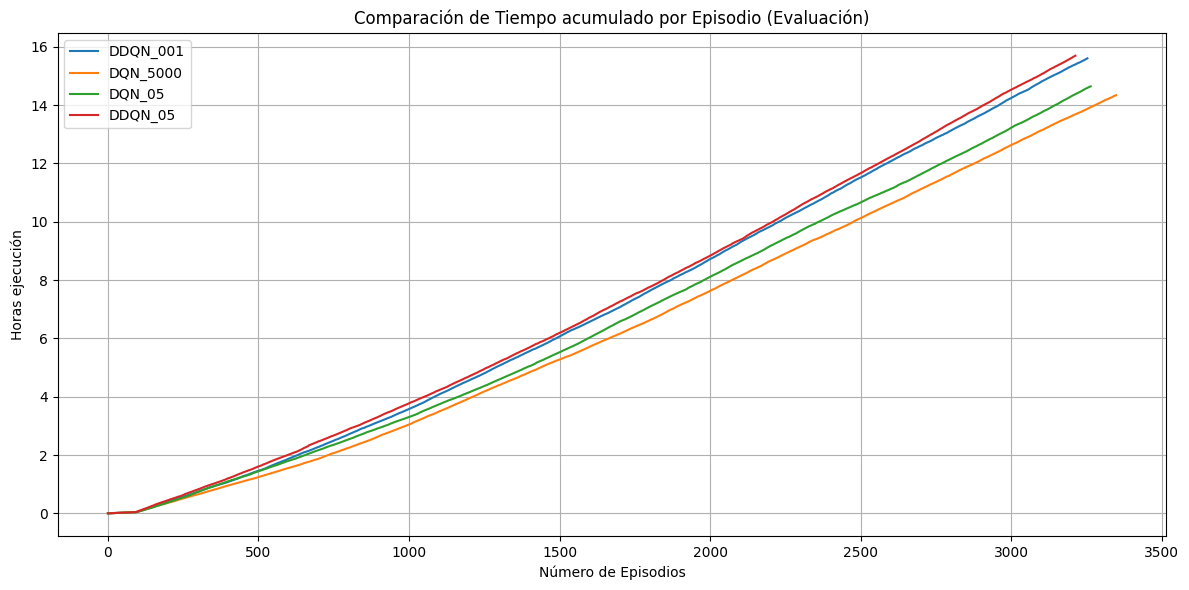

In [22]:
graficar_superpuesto(duracion, 'Tiempo acumulado', 'Horas ejecución', target_reward=0)

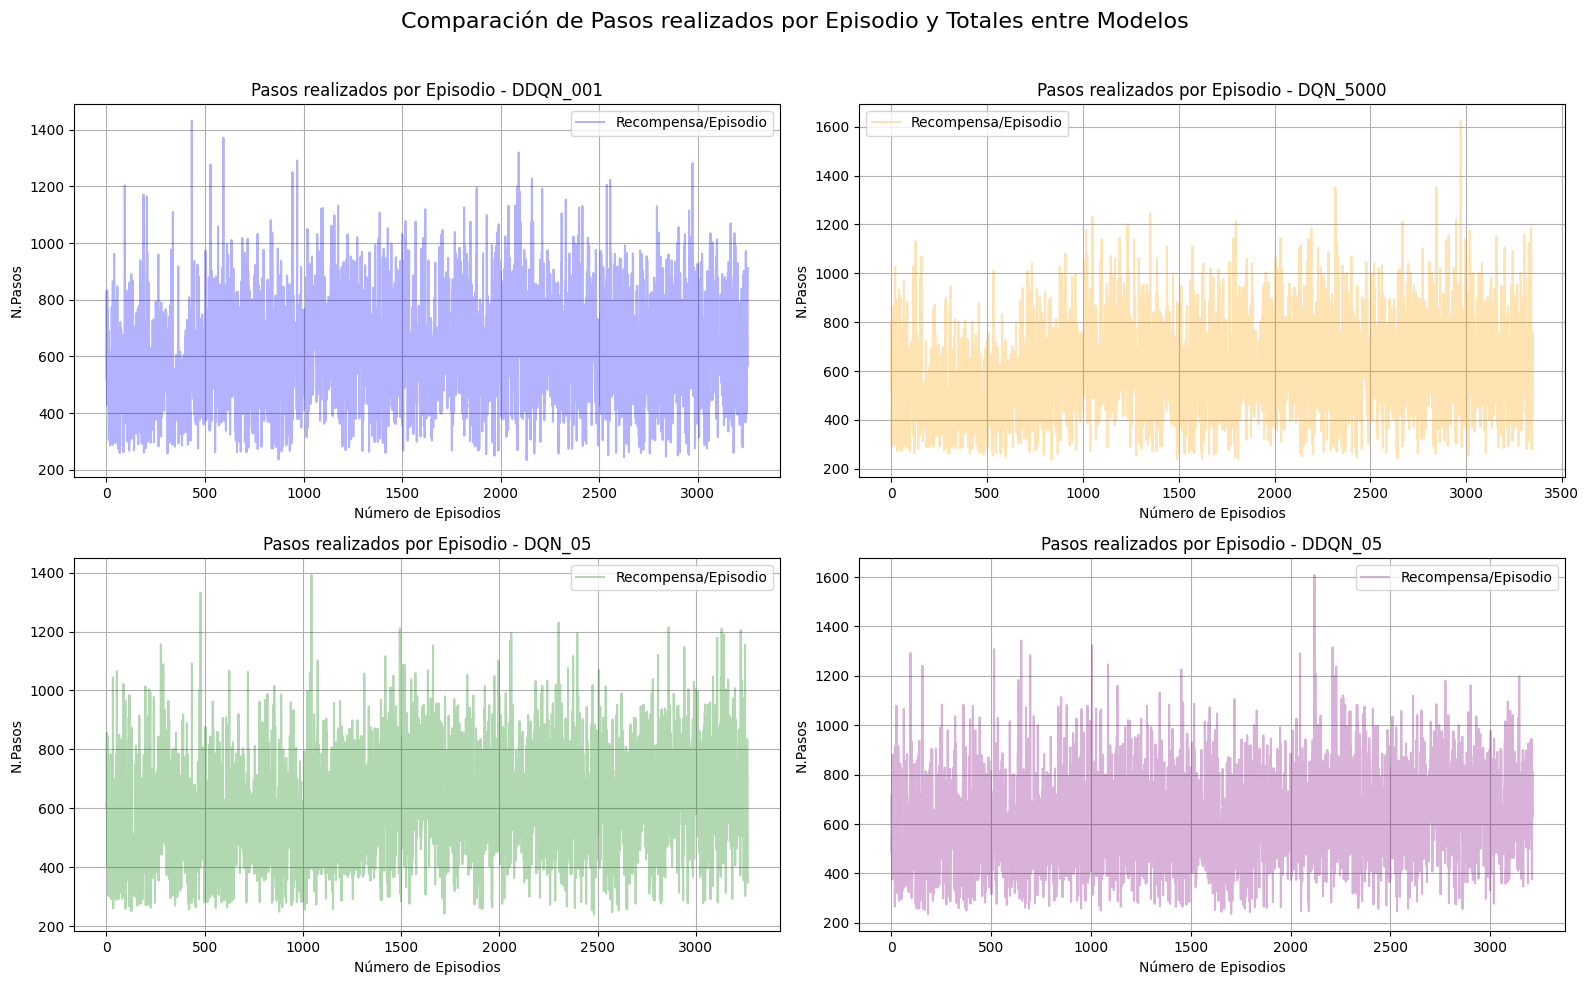

In [23]:
graficar_repartido(pasos, 'Pasos realizados', 'N.Pasos', target_reward=0)

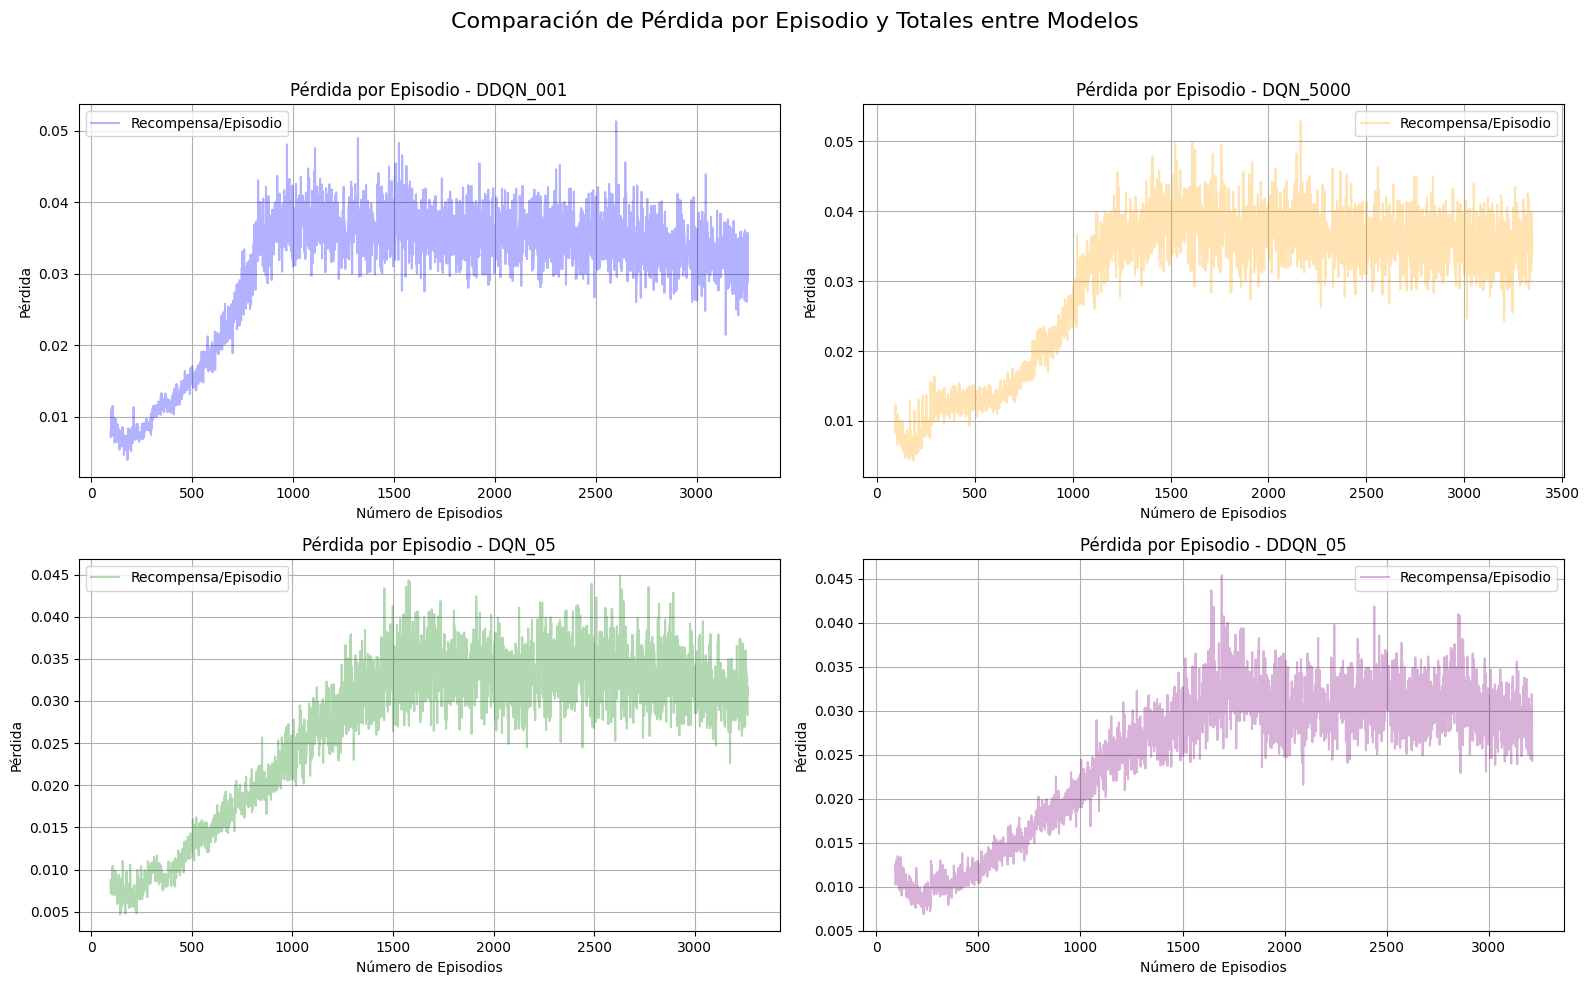

In [24]:
graficar_repartido(loss, 'Pérdida', 'Pérdida', target_reward=0)